# Importing Libraries

In [ ]:
pip install catboost optuna xgboost shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFECV, RFE
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, RandomOverSampler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from tqdm import tqdm

import optuna

# Reading the Data

In [ ]:
drug_data = pd.read_csv('Drug_Consumption.csv')
print('The shape of the dataset is:', drug_data.shape)
drug_data.head()

The shape of the dataset is: (1884, 32)


,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,2,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,3,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,4,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,5,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,6,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0


In [ ]:
# checking for missing values
drug_data.isnull().sum()

,0
ID,0
Age,0
Gender,0
Education,0
Country,0
Ethnicity,0
Nscore,0
Escore,0
Oscore,0
AScore,0


In [ ]:
drug_data.dtypes

,0
ID,int64
Age,object
Gender,object
Education,object
Country,object
Ethnicity,object
Nscore,float64
Escore,float64
Oscore,float64
AScore,float64


In [ ]:
drug_data['Education'].value_counts()

,count
Education,
"Some college or university, no certificate or degree",506
University degree,480
Masters degree,283
Professional certificate/ diploma,269
Left school at 18 years,100
Left school at 16 years,99
Doctorate degree,89
Left school at 17 years,30
Left school before 16 years,28


In [ ]:
drug_data['Country'].value_counts()

,count
Country,
UK,1043
USA,557
Other,118
Canada,87
Australia,54
Republic of Ireland,20
New Zealand,5


In [ ]:
drug_data['Age'].value_counts()

,count
Age,
18-24,643
25-34,481
35-44,355
45-54,294
55-64,93
65+,18


# Preprocessing

In [ ]:
# dropping id column
drug_data = drug_data.drop(columns = 'ID', axis = 1)

# creating column where gender is binary 0/1s, keeping original columns in the dataframe.
drug_data['Gender_0_1'] = np.where(drug_data['Gender'] == 'M', 0, 1)
drug_data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,...,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA,Gender_0_1
0,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0,0
1,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0,0
2,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0,1
3,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0,1
4,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,1.63088,...,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0,1


In [ ]:
# making the range of age to a class
mapping = {'18-24': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55-64': 4, '65+': 5}
drug_data['age_class'] = [mapping[num] for num in drug_data['Age']]

In [ ]:
# making new columns from Education basedon degree obtained
mapping = {'Left school before 16 years': 'No diploma', 'Left school at 17 years': 'No diploma', 'Left school at 16 years': 'No diploma',
           'Left school at 18 years': 'No diploma', 'Professional certificate/ diploma': 'Professional certificate/diploma',
           'Some college or university, no certificate or degree': 'High school diploma', 'University degree': 'Undergraduate degree',
           'Masters degree': 'Masters degree', 'Doctorate degree': 'Doctorate degree'}
drug_data['degree'] = [mapping[num] for num in drug_data['Education']]

mapping = {'No diploma': 0, 'High school diploma': 1, 'Professional certificate/diploma': 2,
           'Undergraduate degree': 3, 'Masters degree': 4, 'Doctorate degree': 5}
drug_data['degree_class'] = [mapping[num] for num in drug_data['degree']]
drug_data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,...,LSD,Meth,Mushrooms,Nicotine,Semer,VSA,Gender_0_1,age_class,degree,degree_class
0,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL2,CL3,CL0,CL4,CL0,CL0,0,1,Doctorate degree,5
1,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL1,CL0,CL0,CL0,0,2,Professional certificate/diploma,2
2,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL0,CL2,CL0,CL0,1,0,Masters degree,4
3,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL0,CL2,CL2,CL0,CL0,1,2,Doctorate degree,5
4,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,1.63088,...,CL0,CL0,CL0,CL6,CL0,CL0,1,5,No diploma,0


Drug consumption class meanings:
* CL0 = Never Used
* CL1 = Used over a decade ago
* CL2 = Used in the last decade
* CL3 = Used in the last year
* CL4 = Used in the last month
* CL5 = Used in the last week
* CL6 = Used in the last day

Since there are seven different classes in this data set, we have decided to combine CL4, CL5, CL6, since the relative time of the last use of the drug is more recent compared to the others.

In [ ]:
mapping = {'CL0': 0, 'CL1': 1, 'CL2': 2, 'CL3': 3, 'CL4': 4, 'CL5': 5, 'CL6': 6}

drug_data[['Alcohol','Amphet','Amyl', 'Benzos','Caff','Cannabis','Choc',
      'Coke','Crack','Ecstasy','Heroin','Ketamine','Legalh','LSD','Meth',
      'Mushrooms','Nicotine','Semer','VSA',]] = drug_data[['Alcohol','Amphet','Amyl', 'Benzos','Caff','Cannabis','Choc',
                                                      'Coke','Crack','Ecstasy','Heroin','Ketamine','Legalh','LSD','Meth',
                                                        'Mushrooms','Nicotine','Semer','VSA',]].replace(mapping).convert_dtypes()

drug_data.head()

<ipython-input-12-df3f414fcf45>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'Mushrooms','Nicotine','Semer','VSA',]].replace(mapping).convert_dtypes()


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,...,LSD,Meth,Mushrooms,Nicotine,Semer,VSA,Gender_0_1,age_class,degree,degree_class
0,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,2,3,0,4,0,0,0,1,Doctorate degree,5
1,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,1,0,0,0,0,2,Professional certificate/diploma,2
2,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,2,0,0,1,0,Masters degree,4
3,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,2,2,0,0,1,2,Doctorate degree,5
4,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,1.63088,...,0,0,0,6,0,0,1,5,No diploma,0


In [ ]:
# subsetting categorical, numerical data, and just the drugs for later purposes of visualization and easier time handling different tasks.
drugs = drug_data[['Alcohol','Amphet','Amyl', 'Benzos','Caff','Cannabis','Choc',
              'Coke','Crack','Ecstasy','Heroin','Ketamine','Legalh','LSD','Meth',
              'Mushrooms','Nicotine','Semer','VSA',]]
data_cata = drug_data[['Age', 'Gender', 'Education', 'degree', 'Country', 'Ethnicity']]
data_num = drug_data.drop(columns = ['Age', 'Gender', 'Education', 'degree', 'Country', 'Ethnicity'], axis = 1)
data_num.head()

,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,...,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA,Gender_0_1,age_class,degree_class
0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,5,2,2,...,0,2,3,0,4,0,0,0,1,5
1,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,6,0,0,...,0,0,0,1,0,0,0,0,2,2
2,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,4,0,0,...,0,0,0,0,2,0,0,1,0,4
3,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,4,1,1,...,1,0,0,2,2,0,0,1,2,5
4,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,2,0,0,...,0,0,0,0,6,0,0,1,5,0


In [ ]:
data_cata.head()

,Age,Gender,Education,degree,Country,Ethnicity
0,25-34,M,Doctorate degree,Doctorate degree,UK,White
1,35-44,M,Professional certificate/ diploma,Professional certificate/diploma,UK,White
2,18-24,F,Masters degree,Masters degree,UK,White
3,35-44,F,Doctorate degree,Doctorate degree,UK,White
4,65+,F,Left school at 18 years,No diploma,Canada,White


In [ ]:
drugs.head()

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0,0
1,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0,0
2,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0,0
3,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0,0
4,2,0,0,0,6,0,4,0,0,0,0,0,0,0,0,0,6,0,0


# Exploratory Data Analysis

## General distribution of variables

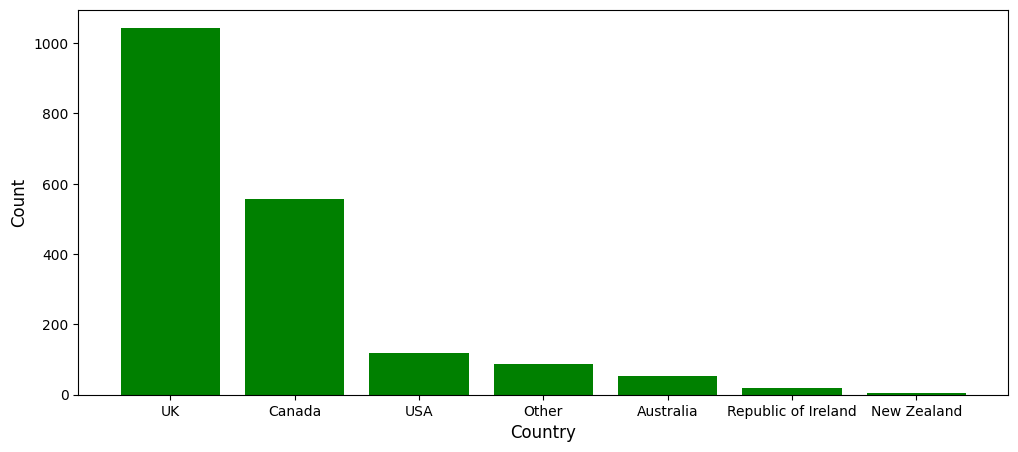

In [ ]:
# exploring country of origin
plt.figure(figsize = (12, 5))
plt.bar(x = drug_data.Country.unique(), height = drug_data.Country.value_counts(), color = 'green')
plt.xlabel('Country', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

From this plot we can see that most of the individuals in this dataset are from the UK. There are some from Canada, U.S., and other Europea countries.

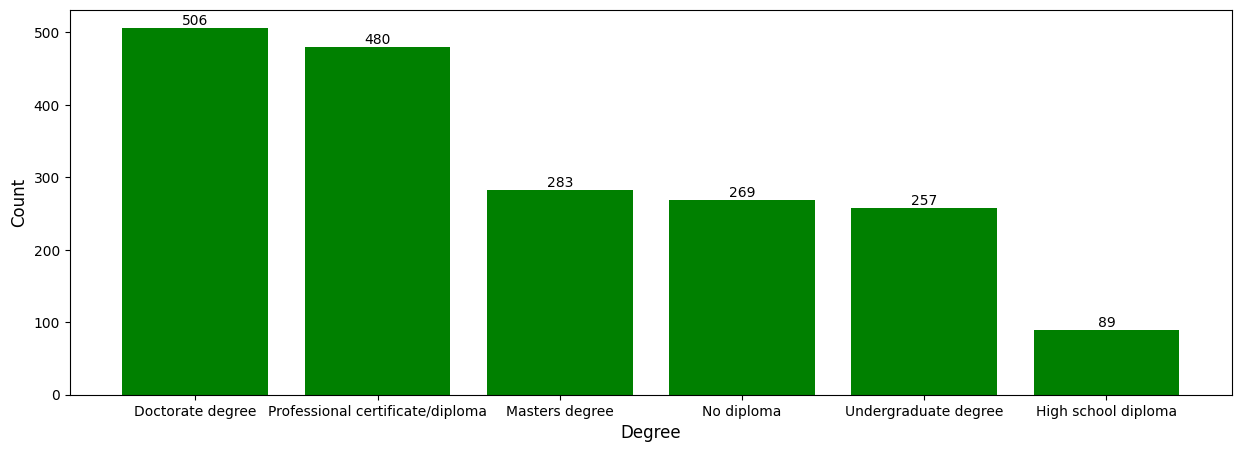

In [ ]:
# exploring levels of education
plt.figure(figsize = (15, 5))
plt.bar(x = drug_data.degree.unique(), height = drug_data.degree.value_counts(), color = 'green')
for i, value in enumerate(drug_data.degree.value_counts()):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom')

plt.xlabel('Degree', fontsize =12)
plt.ylabel('Count', fontsize = 12)
plt.show()

From this plot we can see that most of the individuals havean upper level degree like masters or doctoral, or a proffesional certificate. There are more higher educated individuals compared to those with no highschool or lower level diplomas.

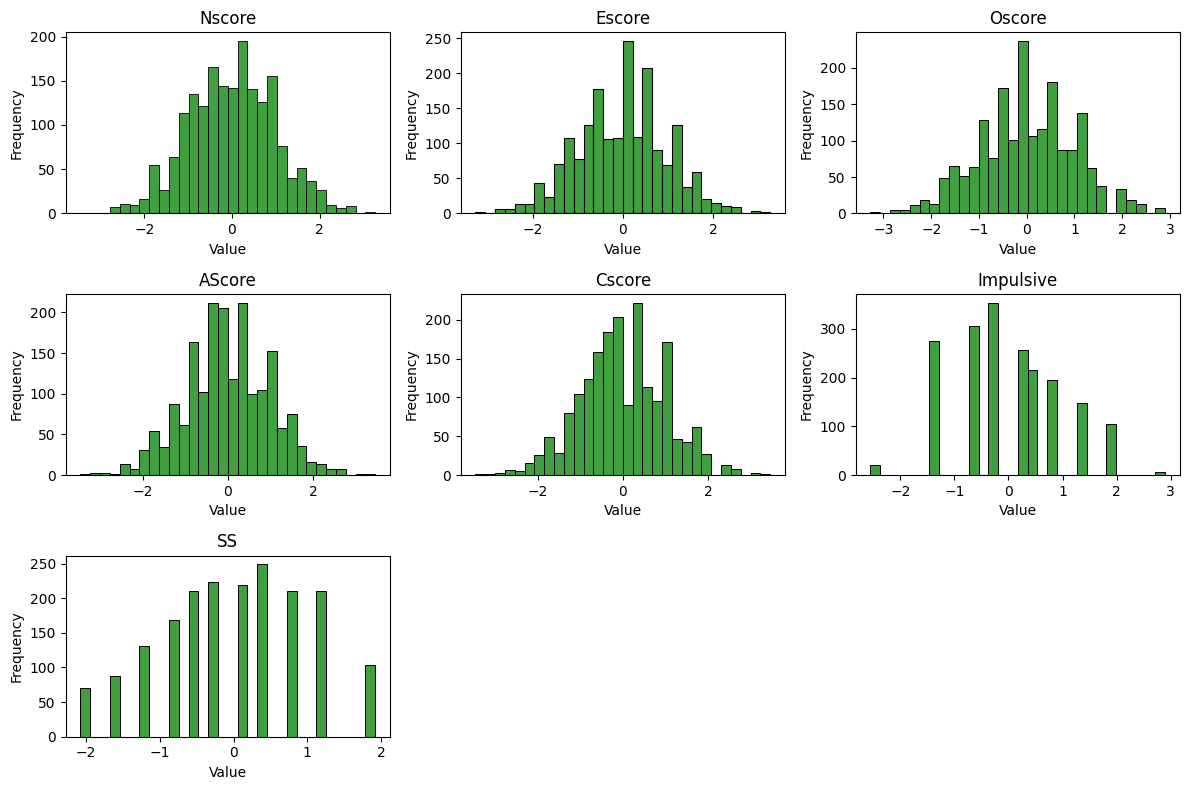

In [ ]:
personality_scores = drug_data[['Nscore','Escore','Oscore','AScore','Cscore','Impulsive','SS']]


plt.figure(figsize=(12, 8))
for i, col in enumerate(personality_scores.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(personality_scores[col], bins=30, color= 'green', edgecolor='black')
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.savefig('hist_personality_plots.png')

From these plots we can't see any significant skews in the data for personality scores. This is most likely because the original makers of the dataset had normalized these scores.

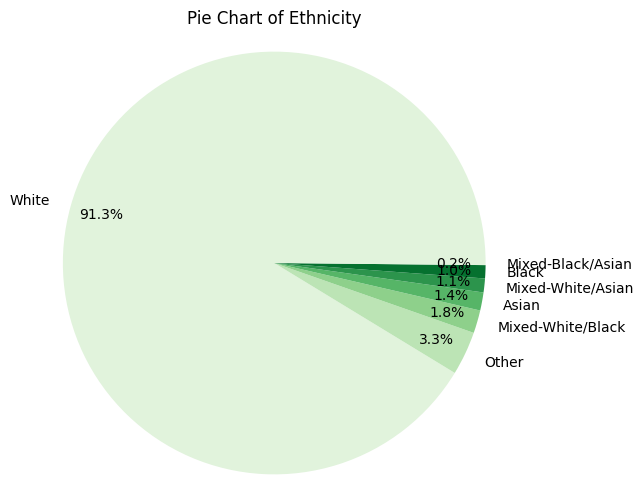

In [ ]:
sizes = drug_data['Ethnicity'].value_counts()
labels = drug_data['Ethnicity'].unique()

plt.figure(figsize=(6,6))
plt.pie(sizes, labels = labels, autopct='%1.1f%%', colors = sns.color_palette('Greens'), pctdistance=0.85)
plt.axis('equal')  # equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart of Ethnicity')
plt.show()


From this pie chart, we can see that majority of the individuals in our dataset are white.

## Further look into drug use

<ipython-input-20-ba31c7f14c4f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = drugs, palette = 'Greens')
<ipython-input-20-ba31c7f14c4f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = drugs, palette = 'Greens')
<ipython-input-20-ba31c7f14c4f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = drugs, palette = 'Greens')
<ipython-input-20-ba31c7f14c4f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` varia

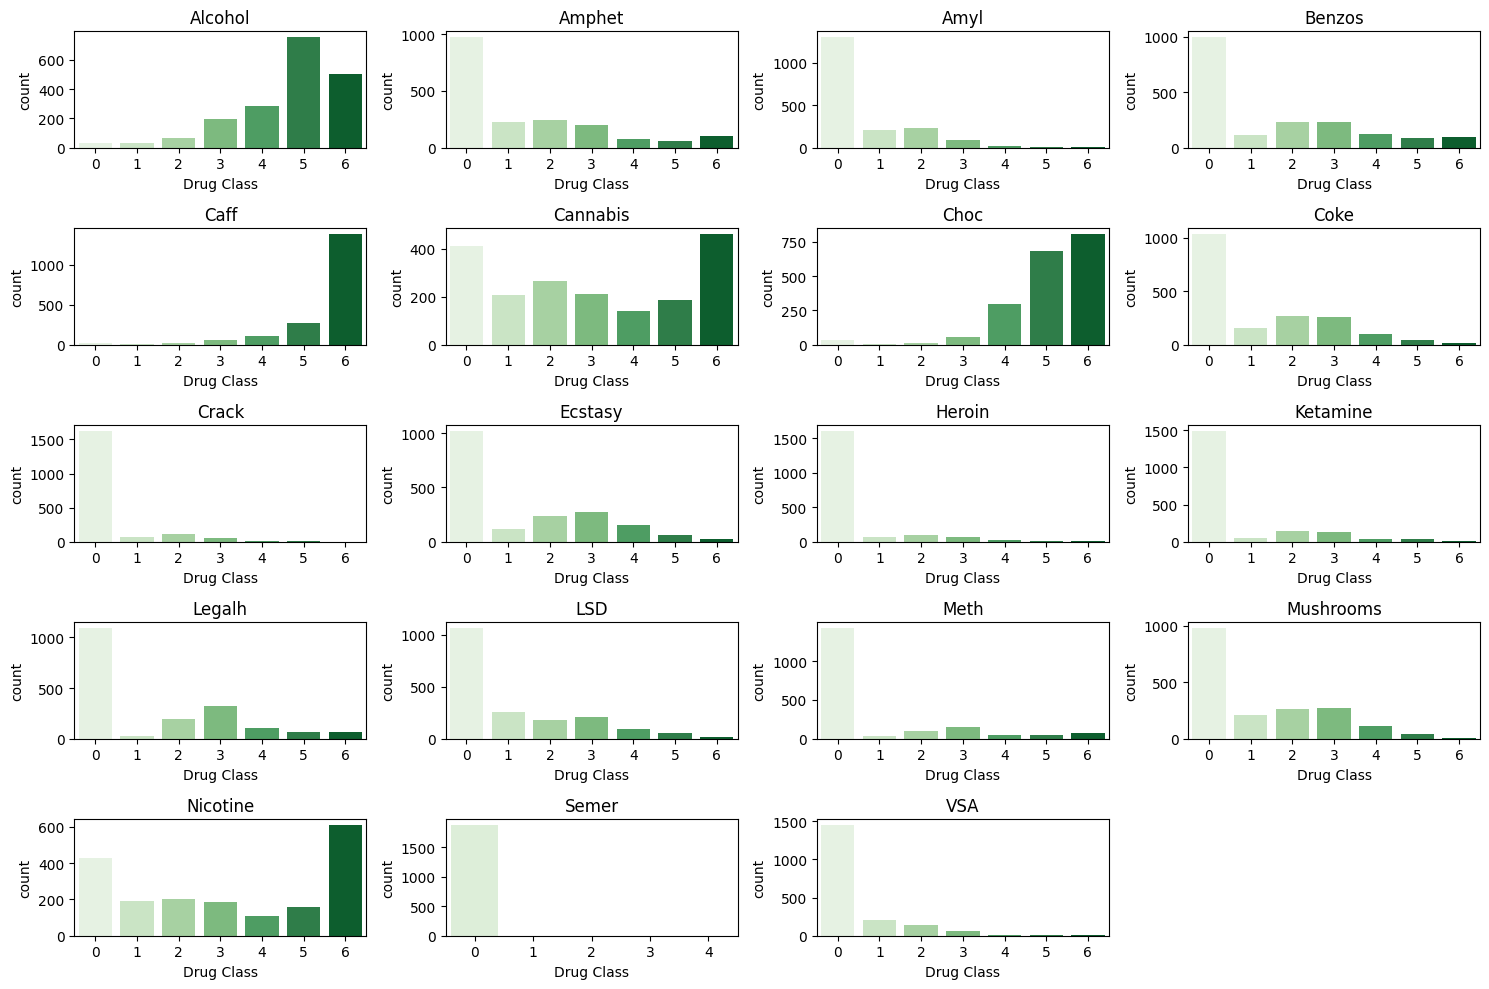

In [ ]:
# exploring the frequency of drug use
plt.figure(figsize=(15, 10))

# loop through each column and create a countplot
for i, column in enumerate(drugs.columns):
    plt.subplot(5, 4, i + 1)  # Adjust the subplot grid based on the number of columns
    sns.countplot(x = column, data = drugs, palette = 'Greens')
    plt.xlabel('Drug Class')
    plt.title(column)

plt.tight_layout()
plt.savefig('freq_drug_use.png')
plt.show()

Notice the drugs with the most frequent users, that is being apart of class 4 which is individuals who have used in the last month. Those drugs are alcohol, caffeine, cannabis, chocolate, and nicotine. So who are the users of some of the drugs that are used more frequently.

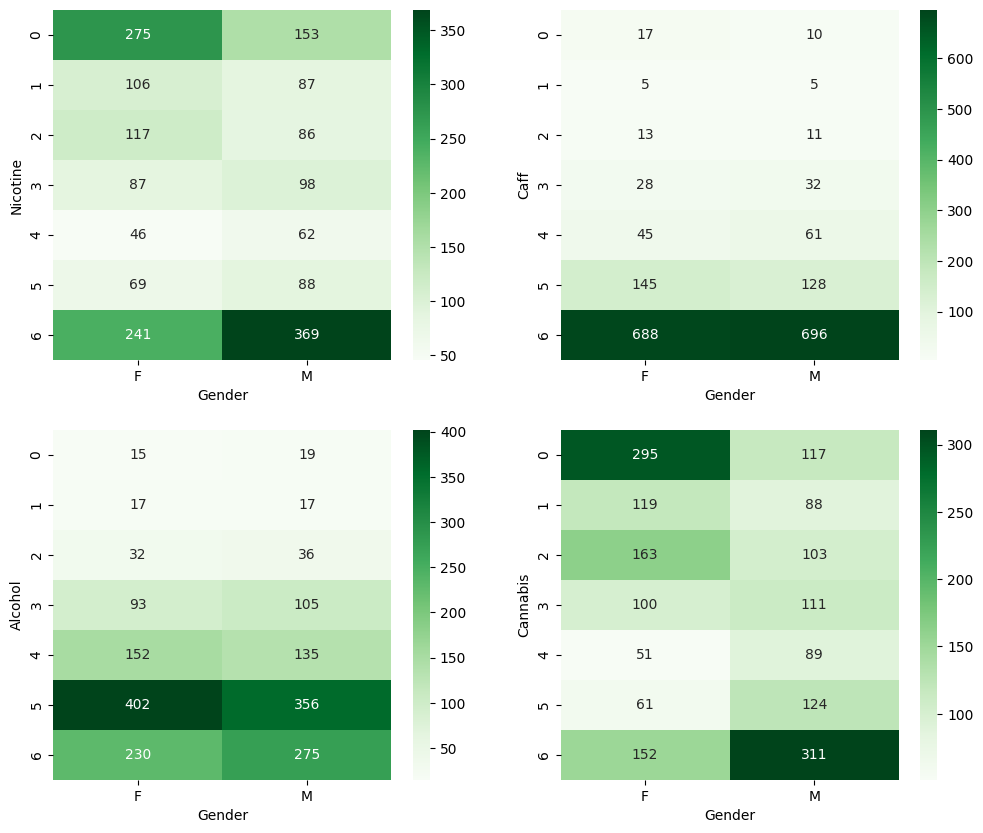

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (12, 10))

# creating heat maps to explore the distribution of men and women throughout the most frequently used drugs.
sns.heatmap(data = pd.crosstab(drug_data['Nicotine'], drug_data['Gender']), annot = True, cmap = 'Greens', fmt = '.0f', ax = axes[0,0])
sns.heatmap(data = pd.crosstab(drug_data['Caff'],drug_data['Gender']), annot = True, cmap = 'Greens', fmt = '.0f', ax = axes[0,1])
sns.heatmap(data = pd.crosstab(drug_data['Alcohol'],drug_data['Gender']), annot = True, cmap = 'Greens', fmt = '.0f', ax = axes[1, 0])
sns.heatmap(data = pd.crosstab(drug_data['Cannabis'],drug_data['Gender']), annot = True, cmap = 'Greens', fmt = '.0f', ax = axes[1, 1])

plt.savefig('drugs_by_gender.png')


From these plots we can see that there are more women than men that have never tried nicotine or cannabis, but there are no major differences between the consumption from men compared to women otherwise.

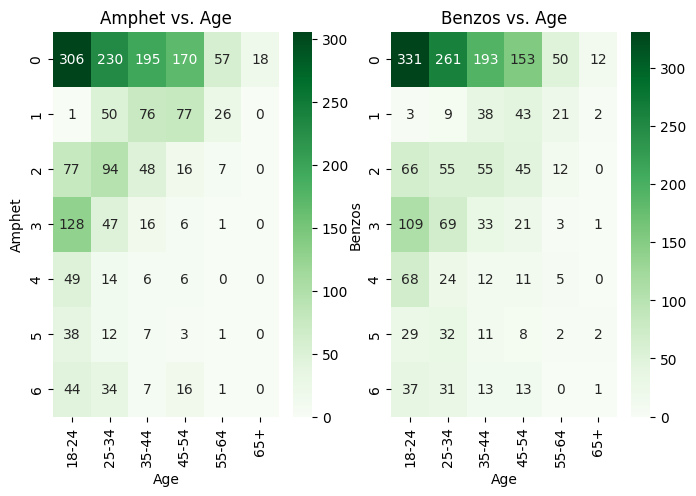

In [ ]:
# exploring some prescription drugs in the dataset
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 5))

sns.heatmap(data = pd.crosstab(drug_data['Amphet'], drug_data['Age']), annot = True, cmap = 'Greens', fmt = '.0f', ax = axes[0])
axes[0].set_title('Amphet vs. Age')
sns.heatmap(data = pd.crosstab(drug_data['Benzos'], drug_data['Age']), annot = True, cmap = 'Greens', fmt = '.0f', ax = axes[1])
axes[1].set_title('Benzos vs. Age')

plt.savefig('prescription_by_age.png')

plt.show()

From this plot we can see that the older the individual there are less observations of those who have never tried these prescription drugs. We also notice the younger you are, there are more individuals that take these medications more frequently than older individuals.

In [ ]:
data = drug_data.copy()

# Prescription Drug Usage

In [ ]:
mapping = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5:1, 6:1}

data[['Alcohol','Amphet','Amyl', 'Benzos','Caff','Cannabis','Choc',
      'Coke','Crack','Ecstasy','Heroin','Ketamine','Legalh','LSD','Meth',
      'Mushrooms','Nicotine','Semer','VSA',]] = data[['Alcohol','Amphet','Amyl', 'Benzos','Caff','Cannabis','Choc',
                                                      'Coke','Crack','Ecstasy','Heroin','Ketamine','Legalh','LSD','Meth',
                                                        'Mushrooms','Nicotine','Semer','VSA',]].replace(mapping).convert_dtypes()

data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,...,LSD,Meth,Mushrooms,Nicotine,Semer,VSA,Gender_0_1,age_class,degree,degree_class
0,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,1,1,0,1,0,0,0,1,Doctorate degree,5
1,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,1,0,0,0,0,2,Professional certificate/diploma,2
2,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,1,0,0,1,0,Masters degree,4
3,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,1,1,0,0,1,2,Doctorate degree,5
4,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,1.63088,...,0,0,0,1,0,0,1,5,No diploma,0


In [ ]:
# for predicting overall prescription drug consumption
data['avg_rx_usage'] = data[['Amphet', 'Benzos']].sum(axis = 1)/2
data['avg_rx_usage'].value_counts()

,count
avg_rx_usage,
0.0,732
1.0,640
0.5,512


In [ ]:
# now need to preprocess further for classification purposes
# 0 = never used either, 0.5 = has least used 1 if them and never used the other, and 1 = has used both
# we will have three classes for this problem now, 0 = never used, 1 = has used one of them, and 2 = has used both of them
mapping = {0:0, 0.5 :1 , 1:2}
data['avg_rx_usage'] = data['avg_rx_usage'].map(mapping)
data['avg_rx_usage'].value_counts()

,count
avg_rx_usage,
0,732
2,640
1,512


In [ ]:
def preprocess_data(data):
    # Normalize inputs (for instance, scaling values between 0 and 1)
    normalized_data = {key: value / 10.0 for key, value in data.items()}
    return normalized_data


<ipython-input-28-41b130ad8ad7>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = data['avg_rx_usage'], data = data, palette = 'Greens')


Text(0.5, 1.0, 'Count of Classes for RX Usage')

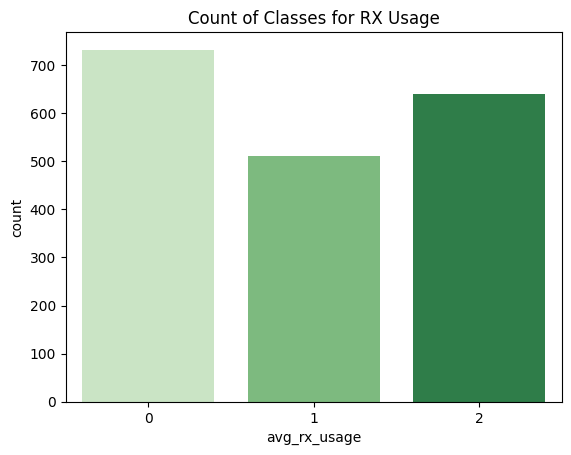

In [ ]:
sns.countplot(x = data['avg_rx_usage'], data = data, palette = 'Greens')
plt.title('Count of Classes for RX Usage')

# Feature Engineering

In [ ]:
data['overall_personality'] = data[['Nscore', 'Escore', 'Oscore', 'Cscore', 'AScore', 'Impulsive', 'SS']].sum(axis = 1)
data['overall_personality'].describe()

,overall_personality
count,1884.000000
mean,0.004325
std,2.882440
min,-11.225880
25%,-1.942000
50%,-0.047105
75%,1.928330
max,10.557160


In [ ]:
data.columns.tolist()

['Age',
 'Gender',
 'Education',
 'Country',
 'Ethnicity',
 'Nscore',
 'Escore',
 'Oscore',
 'AScore',
 'Cscore',
 'Impulsive',
 'SS',
 'Alcohol',
 'Amphet',
 'Amyl',
 'Benzos',
 'Caff',
 'Cannabis',
 'Choc',
 'Coke',
 'Crack',
 'Ecstasy',
 'Heroin',
 'Ketamine',
 'Legalh',
 'LSD',
 'Meth',
 'Mushrooms',
 'Nicotine',
 'Semer',
 'VSA',
 'Gender_0_1',
 'age_class',
 'degree',
 'degree_class',
 'avg_rx_usage',
 'overall_personality']

In [ ]:
data.isnull().sum()

,0
Age,0
Gender,0
Education,0
Country,0
Ethnicity,0
Nscore,0
Escore,0
Oscore,0
AScore,0
Cscore,0


# Modeling prescription drug usage

## ExtraTreesClassifier

In [ ]:
X = data.drop(columns = ['avg_rx_usage', 'Age','Gender','Education','Country','Ethnicity', 'degree', 'Amphet', 'Benzos'], axis = 1)
Y = data['avg_rx_usage']

Y.isnull().sum()

imp_results = list()

skf = RepeatedStratifiedKFold(n_splits = 5,n_repeats = 1, random_state= 10)

for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    perm_md = ExtraTreesClassifier(n_estimators = 200, max_depth = 3)

    perm_md.fit(X_train, Y_train)

    result_imp = permutation_importance(perm_md, X_test,Y_test, scoring = 'accuracy', n_repeats = 20, random_state= 42)

    imp_results.append(result_imp.importances)

imp_results_mean = np.mean(np.concatenate(imp_results, axis= 1),axis = 1)

imp_results_sd = np.std(np.concatenate(imp_results, axis= 1), ddof = 1,axis =1)

data_out = pd.DataFrame({'Feature':X.columns, 'Mean':imp_results_mean, 'SD':imp_results_sd})

data_out = data_out.sort_values(by = 'Mean', ascending = False)

data_out = data_out.reset_index(drop = True)

Text(0.5, 1.0, 'Feature Importance for Extra Trees')

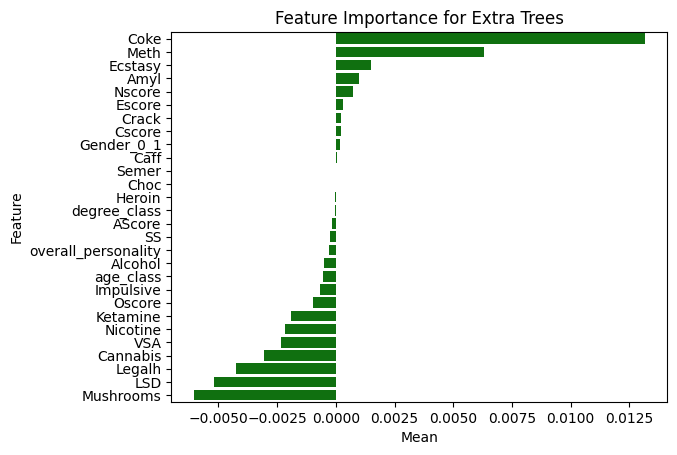

In [ ]:
sns.barplot(x = data_out['Mean'], y = data_out['Feature'], color = 'green')
plt.title('Feature Importance for Extra Trees')

In [ ]:
et_x_select = ['Coke','Meth','Ecstasy', 'Nscore']

In [ ]:
X = data[et_x_select]
Y = data['avg_rx_usage']

skf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 25)

et_md = ExtraTreesClassifier(n_estimators = 500, max_depth = 3)

et_cv = cross_val_score(et_md, X, Y,
                        scoring = 'accuracy',
                        cv = skf,
                        n_jobs = -1)

print('The average accuracy score of the untuned ET model across 5 folds is:', et_cv.mean())

The average accuracy score of the untuned ET model across 5 folds is: 0.6497917489700322


In [ ]:
class ET_Objective:

    def __init__(self, X, Y, seed):
        # Hold this implementation specific arguments as the fields of the class.
        self.X = X
        self.Y = Y
        self.seed = seed

    def __call__(self, trial):

        ## Parameters to be evaluated
        params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 500),
                      min_samples_split = trial.suggest_int('min_samples_split', 5, 30),
                      min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 30),
                      max_depth = trial.suggest_int('max_depth', 2, 10)
                     )

        skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=self.seed)

        cv_run = cross_val_score(ExtraTreesClassifier(**params),
                                 self.X,
                                 self.Y,
                                 scoring = 'accuracy',
                                 cv = skf,
                                 n_jobs = -1)

        return cv_run.mean()

SEED = 42
N_TRIALS = 100

# Execute an optimization
et_study = optuna.create_study(direction = 'maximize')
et_study.optimize(ET_Objective(X[et_x_select], Y, SEED), n_trials = N_TRIALS, n_jobs = -1)

[I 2024-12-09 01:05:54,119] A new study created in memory with name: no-name-187dfab1-a863-40c9-a0a7-4f18892c626f
[I 2024-12-09 01:06:00,396] Trial 0 finished with value: 0.6465411460092312 and parameters: {'n_estimators': 297, 'min_samples_split': 26, 'min_samples_leaf': 9, 'max_depth': 3}. Best is trial 0 with value: 0.6465411460092312.
[I 2024-12-09 01:06:00,759] Trial 1 finished with value: 0.6513171225937183 and parameters: {'n_estimators': 182, 'min_samples_split': 30, 'min_samples_leaf': 24, 'max_depth': 8}. Best is trial 1 with value: 0.6513171225937183.
[I 2024-12-09 01:06:05,834] Trial 2 finished with value: 0.6529072385455363 and parameters: {'n_estimators': 299, 'min_samples_split': 11, 'min_samples_leaf': 19, 'max_depth': 8}. Best is trial 2 with value: 0.6529072385455363.
[I 2024-12-09 01:06:06,406] Trial 3 finished with value: 0.6497270066419003 and parameters: {'n_estimators': 311, 'min_samples_split': 25, 'min_samples_leaf': 27, 'max_depth': 6}. Best is trial 2 with va

In [ ]:
X = data[et_x_select]
Y = data['avg_rx_usage']

skf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 25)

et_md_tuned = ExtraTreesClassifier(**et_study.best_params)

et_cv_tuned = cross_val_score(et_md_tuned, X, Y,
                        scoring = 'accuracy',
                        cv = skf,
                        n_jobs = -1)

print('The average accuracy score of the tuned ET model across 5 folds is:', et_cv_tuned.mean())

The average accuracy score of the tuned ET model across 5 folds is: 0.6514890795191604


## XGBoost

In [ ]:
X = data.drop(columns = ['avg_rx_usage', 'Age','Gender','Education','Country','Ethnicity', 'degree', 'Amphet', 'Benzos'], axis = 1)
Y = data['avg_rx_usage']

imp_results = list()

skf = RepeatedStratifiedKFold(n_splits= 5,n_repeats = 1, random_state= 10)

for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    perm_md = XGBClassifier(objective = 'multi:softmax', n_estimators = 100, learning_rate = 0.1)

    perm_md.fit(X_train, Y_train)

    result_imp = permutation_importance(perm_md, X_test,Y_test, scoring = 'accuracy', n_repeats = 20, random_state= 42)

    imp_results.append(result_imp.importances)

imp_results_mean = np.mean(np.concatenate(imp_results, axis= 1),axis = 1)

imp_results_sd = np.std(np.concatenate(imp_results, axis= 1), ddof = 1,axis =1)

data_out = pd.DataFrame({'Feature':X.columns, 'Mean':imp_results_mean, 'SD':imp_results_sd})

data_out = data_out.sort_values(by = 'Mean', ascending = False)

data_out = data_out.reset_index(drop = True)

Text(0.5, 1.0, 'Feature Importance for XGBoost')

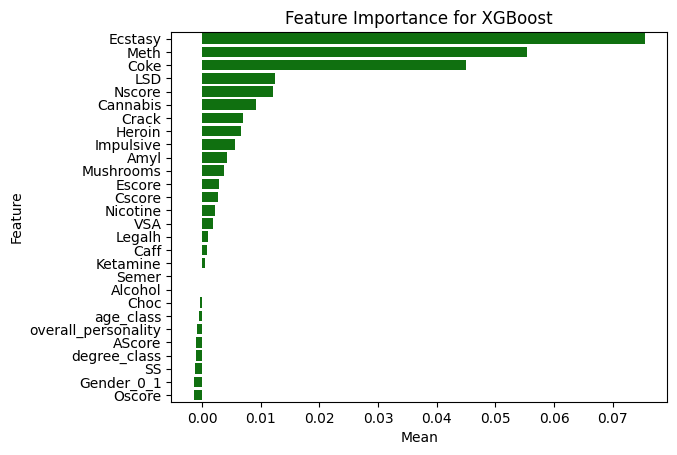

In [ ]:
sns.barplot(x = data_out['Mean'], y = data_out['Feature'], color = 'green')
plt.title('Feature Importance for XGBoost')

In [ ]:
data_out.Feature.tolist()

['Ecstasy',
 'Meth',
 'Coke',
 'LSD',
 'Nscore',
 'Cannabis',
 'Crack',
 'Heroin',
 'Impulsive',
 'Amyl',
 'Mushrooms',
 'Escore',
 'Cscore',
 'Nicotine',
 'VSA',
 'Legalh',
 'Caff',
 'Ketamine',
 'Semer',
 'Alcohol',
 'Choc',
 'age_class',
 'overall_personality',
 'AScore',
 'degree_class',
 'SS',
 'Gender_0_1',
 'Oscore']

In [ ]:
xgb_x_select = ['Ecstasy','Meth','Coke','LSD','Nscore', 'Cannabis', 'Crack']

In [ ]:
X = data[xgb_x_select]
Y = data['avg_rx_usage']

skf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 25)

xgb_md = XGBClassifier(objective = 'multi:softmax', n_estimators = 100, learning_rate = 0.1)

xgb_cv = cross_val_score(xgb_md, X, Y,
                        scoring = 'accuracy',
                        cv = skf,
                        n_jobs = -1)

print('The average accuracy score of the untuned XGB model across 5 folds is:', xgb_cv.mean())

The average accuracy score of the untuned XGB model across 5 folds is: 0.6536077092386704


In [ ]:
class XGB_Objective:
    def __init__(self, X, Y, seed):
        # Hold this implementation specific arguments as the fields of the class.
        self.X = X
        self.Y = Y
        self.seed = seed
    def __call__(self, trial):

        params = {'objective': 'multi:softmax',
                  'max_depth' : trial.suggest_int('max_depth', 3, 10),
                  'max_leaves' : trial.suggest_int('max_leaves', 2, 20),
                  'learning_rate' : trial.suggest_float('learning_rate', 1e-3, 1e-1, log = True),
                  'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
                  'gamma' : trial.suggest_float('gamma', 0, 10),
                  'subsample' : trial.suggest_float('subsample', 0.5, 0.9)
                 }
        skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = self.seed)

        cv_run = cross_val_score(XGBClassifier(**params),
                                 self.X,
                                 self.Y,
                                 scoring = 'accuracy',
                                 cv = skf,
                                 n_jobs = -1)

        return cv_run.mean()

SEED = 42
N_TRIALS = 100

# executing optimization
xgb_study = optuna.create_study(direction = 'maximize')
xgb_study.optimize(XGB_Objective(X[xgb_x_select], Y, SEED), n_trials = N_TRIALS, n_jobs = -1)

[I 2024-12-09 01:12:45,747] A new study created in memory with name: no-name-a76ad457-360e-438c-830d-7862af512a23
[I 2024-12-09 01:12:49,235] Trial 1 finished with value: 0.6752026342451873 and parameters: {'max_depth': 9, 'max_leaves': 20, 'learning_rate': 0.03823754171613956, 'n_estimators': 448, 'gamma': 5.282561554070734, 'subsample': 0.7695292066343067}. Best is trial 1 with value: 0.6752026342451873.
[I 2024-12-09 01:12:49,686] Trial 0 finished with value: 0.6730862321287854 and parameters: {'max_depth': 8, 'max_leaves': 3, 'learning_rate': 0.027494838333336546, 'n_estimators': 486, 'gamma': 3.357104522876453, 'subsample': 0.6273499464967797}. Best is trial 1 with value: 0.6752026342451873.
[I 2024-12-09 01:12:54,256] Trial 2 finished with value: 0.6438984577282449 and parameters: {'max_depth': 10, 'max_leaves': 9, 'learning_rate': 0.004038512978020597, 'n_estimators': 258, 'gamma': 7.983889212444854, 'subsample': 0.6747163149334121}. Best is trial 1 with value: 0.675202634245187

In [ ]:
X = data[xgb_x_select]
Y = data['avg_rx_usage']

skf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 25)

xgb_md_tuned = XGBClassifier(**xgb_study.best_params)

xgb_cv_tuned = cross_val_score(xgb_md_tuned, X, Y,
                        scoring = 'accuracy',
                        cv = skf,
                        n_jobs = -1)

print('The average accuracy score of the untuned XGB model across 5 folds is:', xgb_cv_tuned.mean())

The average accuracy score of the untuned XGB model across 5 folds is: 0.6718711552570685


## CatBoost

In [ ]:
X = data.drop(columns = ['avg_rx_usage', 'Age','Gender','Education','Country','Ethnicity', 'Amphet', 'degree', 'Benzos'], axis = 1)
Y = data['avg_rx_usage']

imp_results = list()

skf = RepeatedStratifiedKFold(n_splits= 5,n_repeats = 1, random_state= 10)

for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    perm_md = CatBoostClassifier(iterations = 100, depth = 3, loss_function = 'MultiClass', verbose = 0)

    perm_md.fit(X_train, Y_train)

    result_imp = permutation_importance(perm_md, X_test,Y_test, scoring = 'accuracy', n_repeats = 20, random_state= 42)

    imp_results.append(result_imp.importances)

imp_results_mean = np.mean(np.concatenate(imp_results, axis= 1),axis = 1)

imp_results_sd = np.std(np.concatenate(imp_results, axis= 1), ddof = 1,axis =1)

data_out = pd.DataFrame({'Feature':X.columns, 'Mean':imp_results_mean, 'SD':imp_results_sd})

data_out = data_out.sort_values(by = 'Mean', ascending = False)

data_out = data_out.reset_index(drop = True)

Text(0.5, 1.0, 'Feature Importance for Cat Boost')

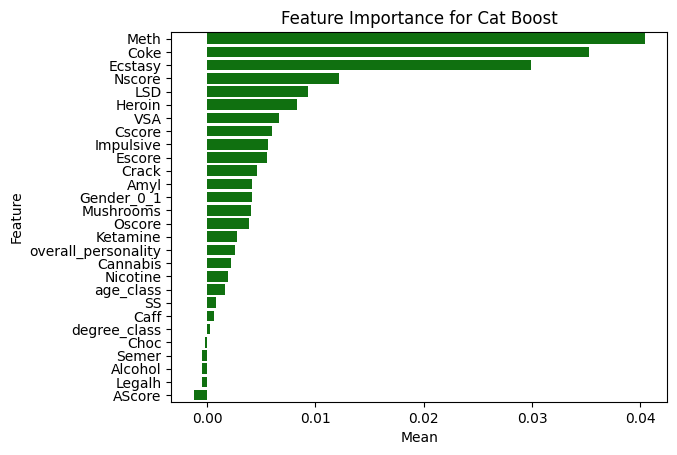

In [ ]:
sns.barplot(x = data_out['Mean'], y = data_out['Feature'], color = 'green')
plt.title('Feature Importance for Cat Boost')

In [ ]:
data_out.Feature.tolist()

['Meth',
 'Coke',
 'Ecstasy',
 'Nscore',
 'LSD',
 'Heroin',
 'VSA',
 'Cscore',
 'Impulsive',
 'Escore',
 'Crack',
 'Amyl',
 'Gender_0_1',
 'Mushrooms',
 'Oscore',
 'Ketamine',
 'overall_personality',
 'Cannabis',
 'Nicotine',
 'age_class',
 'SS',
 'Caff',
 'degree_class',
 'Choc',
 'Semer',
 'Alcohol',
 'Legalh',
 'AScore']

In [ ]:
cat_x_select = ['Meth', 'Coke','Ecstasy','Nscore','LSD','Heroin']

In [ ]:
X = data[cat_x_select]
Y = data['avg_rx_usage']

skf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 25)

cat_md = CatBoostClassifier(iterations = 250, depth = 3, loss_function = 'MultiClass', verbose = 0)

cat_cv = cross_val_score(cat_md, X, Y,
                        scoring = 'accuracy',
                        cv = skf,
                        n_jobs = -1)

print('The average accuracy score of the untuned CAT model across 5 folds is:', cat_cv.mean())

The average accuracy score of the untuned CAT model across 5 folds is: 0.6562664371578532


In [ ]:
class CAT_Objective:
    def __init__(self, X, Y, seed):
        # Hold this implementation specific arguments as the fields of the class.
        self.X = X
        self.Y = Y
        self.seed = seed
    def __call__(self, trial):

        params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log = True),
        'depth': trial.suggest_int('depth', 3, 10),
        'loss_function': 'MultiClass',
        'verbose': False
    }
        skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = self.seed)

        cv_run = cross_val_score(CatBoostClassifier(**params),
                                 self.X,
                                 self.Y,
                                 scoring = 'accuracy',
                                 cv = skf,
                                 n_jobs = -1)

        return cv_run.mean()

SEED = 42
N_TRIALS = 100

# executing optimization
cat_study = optuna.create_study(direction = 'maximize')
cat_study.optimize(CAT_Objective(X[cat_x_select], Y, SEED), n_trials = N_TRIALS, n_jobs = -1)

[I 2024-12-09 01:16:13,158] A new study created in memory with name: no-name-52746ef4-89bc-4f22-9f36-af65c6ac472b
[I 2024-12-09 01:16:35,840] Trial 0 finished with value: 0.6640661938534279 and parameters: {'iterations': 398, 'learning_rate': 0.01214466248495889, 'depth': 7}. Best is trial 0 with value: 0.6640661938534279.
[I 2024-12-09 01:16:39,608] Trial 1 finished with value: 0.655032083755488 and parameters: {'iterations': 454, 'learning_rate': 0.020934440549750615, 'depth': 10}. Best is trial 0 with value: 0.6640661938534279.
[I 2024-12-09 01:16:51,586] Trial 2 finished with value: 0.6581926151075088 and parameters: {'iterations': 461, 'learning_rate': 0.11540606416848699, 'depth': 4}. Best is trial 0 with value: 0.6640661938534279.
[I 2024-12-09 01:16:53,161] Trial 3 finished with value: 0.651846223122819 and parameters: {'iterations': 295, 'learning_rate': 0.04864708043436434, 'depth': 9}. Best is trial 0 with value: 0.6640661938534279.
[I 2024-12-09 01:16:56,987] Trial 4 finish

In [ ]:
cat_study.best_params

{'iterations': 445, 'learning_rate': 0.0487345015665211, 'depth': 3}

In [ ]:
X = data[cat_x_select]
Y = data['avg_rx_usage']

skf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 25)

cat_md_tuned = CatBoostClassifier(**cat_study.best_params,verbose = 0)

cat_cv_tuned = cross_val_score(cat_md_tuned, X, Y,
                        scoring = 'accuracy',
                        cv = skf,
                        n_jobs = -1)

print('The average accuracy score of the tuned CAT model across 5 folds is:', cat_cv_tuned.mean())

The average accuracy score of the tuned CAT model across 5 folds is: 0.6664529600993283


# "Party" Drugs

In [ ]:
# taking a look at "party drugs", what makes a person at risk for trying party drugs (non RX)?
data['party_drugs'] = data[['Coke', 'LSD', 'Ecstasy']].sum(axis = 1)/3
data['party_drugs'].value_counts()

,count
party_drugs,
0.0,760
1.0,513
0.666667,377
0.333333,234


In [ ]:
# from this above, we can see majority of the individuals in thi dataset have tried at least one of these drugs LSD, Coke, or Ecstasy
## We can change this to a binary prediction to see if we can correctly predict if someone has never used or has used party drugs
## We can see what factors best predict whether someone has or has not used these party drugs.

In [ ]:
data['party_drugs'] = np.where(data['party_drugs'] == 0, 0, 1)
data['party_drugs'].value_counts()

,count
party_drugs,
1,1124
0,760


<ipython-input-56-bfa657bf5b0d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = data['party_drugs'], data = data, palette = 'Greens')


Text(0.5, 1.0, 'Count of Classes for Party Drug Usage')

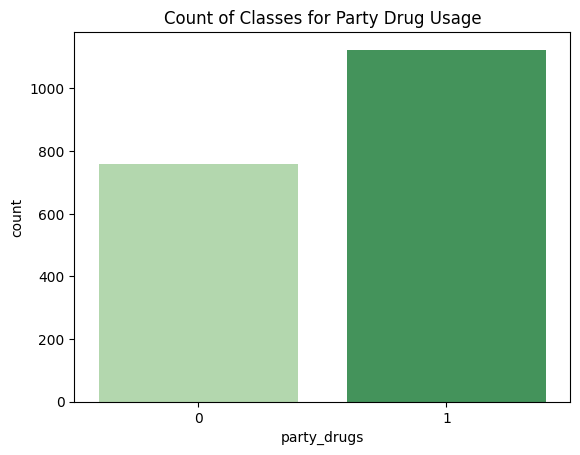

In [ ]:
sns.countplot(x = data['party_drugs'], data = data, palette = 'Greens')
plt.title('Count of Classes for Party Drug Usage')

## XGBoost

In [ ]:
X = data.drop(columns = ['avg_rx_usage', 'Age','Gender','Education','Country','Ethnicity',
                         'degree', 'avg_rx_usage', 'party_drugs', 'Ecstasy', 'LSD', 'Coke'], axis = 1)
Y = data['party_drugs']

imp_results = list()

skf = RepeatedStratifiedKFold(n_splits= 5,n_repeats = 1, random_state= 10)

for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    perm_md = XGBClassifier(n_estimators = 100, learning_rate = 0.1)

    perm_md.fit(X_train, Y_train)

    result_imp = permutation_importance(perm_md, X_test,Y_test, scoring = 'accuracy', n_repeats = 20, random_state= 42)

    imp_results.append(result_imp.importances)

imp_results_mean = np.mean(np.concatenate(imp_results, axis= 1),axis = 1)

imp_results_sd = np.std(np.concatenate(imp_results, axis= 1), ddof = 1,axis =1)

data_out = pd.DataFrame({'Feature':X.columns, 'Mean':imp_results_mean, 'SD':imp_results_sd})

data_out = data_out.sort_values(by = 'Mean', ascending = False)

data_out = data_out.reset_index(drop = True)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define a simple logistic surrogate model
def surrogate_model(X):
    logistic = LogisticRegression()
    logistic.fit(X_train, Y_train)
    return logistic.predict_proba(X)[:, 1]  # Probability for the positive class


In [ ]:
from xgboost import XGBClassifier

# Train the XGBoost model on errors (correcting the surrogate)
xgboost_model = XGBClassifier(n_estimators=100, learning_rate=0.1)

# Calculate surrogate model predictions
surrogate_preds = surrogate_model(X_train)

# Calculate residual errors: Actual - Surrogate predictions
error_labels = Y_train - surrogate_preds

# Binarize the errors
error_labels = (Y_train - surrogate_preds > 0).astype(int)

# Train XGBoost on binary error labels
xgboost_model = XGBClassifier(n_estimators=100, learning_rate=0.1)
xgboost_model.fit(X_train, error_labels)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
def digital_twin_model(X):
    # Surrogate model predictions
    surrogate_preds = surrogate_model(X)

    # Error correction from XGBoost
    error_corrections = xgboost_model.predict(X)

    # Final predictions are the surrogate + corrections from XGBoost
    final_preds = surrogate_preds + error_corrections
    return final_preds


In [ ]:
pip install openai==0.27.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5


Digital Twin Test Accuracy: 0.88
Confusion Matrix:
[[124  28]
 [ 18 206]]


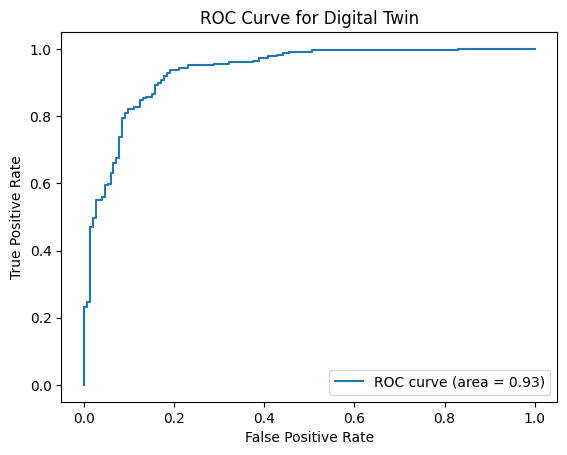

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions from the digital twin model
digital_twin_preds = digital_twin_model(X_test)

# Binary classification (1 if the prediction > 0.5)
final_preds_binary = (digital_twin_preds >= 0.5).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(Y_test, final_preds_binary)
print(f"Digital Twin Test Accuracy: {accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(Y_test, final_preds_binary)
print(f"Confusion Matrix:\n{cm}")

# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, digital_twin_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Digital Twin')
plt.legend(loc="lower right")
plt.show()


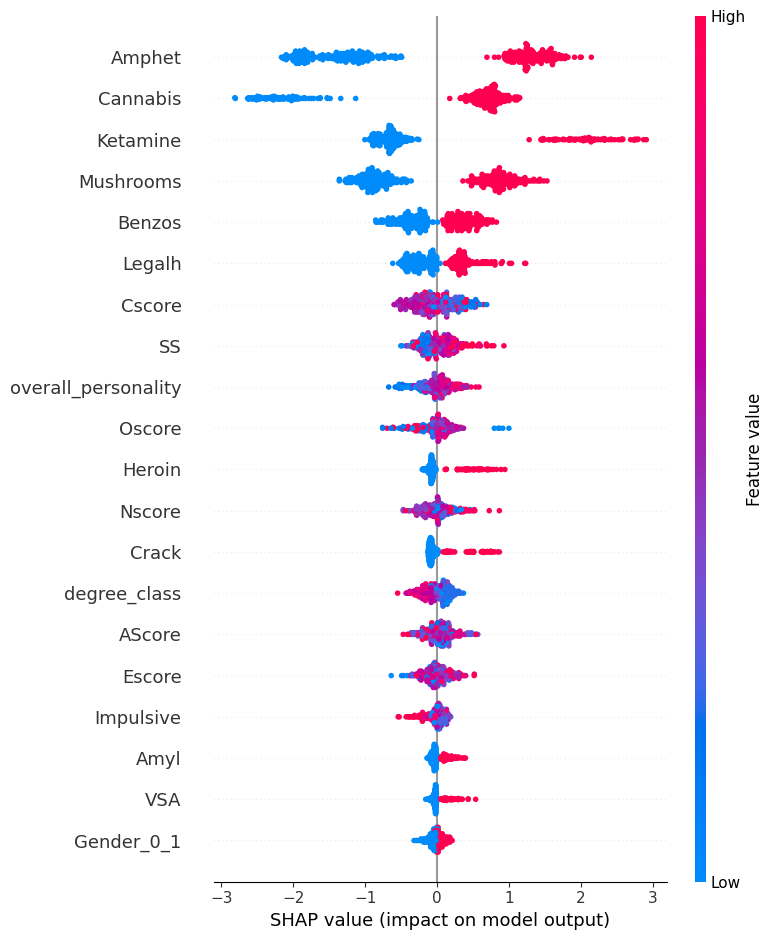

In [ ]:
import shap


X_test = X_test.astype('float64')

# SHAP explainer for the XGBoost model
explainer = shap.Explainer(xgboost_model, X_test)
shap_values = explainer(X_test)

# Summary plot to show feature importance
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Example of tuning XGBoost hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, error_labels)
best_xgboost_model = grid_search.best_estimator_

# Use the tuned XGBoost in the digital twin
def tuned_digital_twin_model(X):
    surrogate_preds = surrogate_model(X)
    error_corrections = best_xgboost_model.predict(X)
    return surrogate_preds + error_corrections


In [ ]:
# Sample individual data (features for one individual)
user_data = {
    'Nscore': 35,      # Neuroticism score
    'Escore': 45,      # Extraversion score
    'Oscore': 55,      # Openness to experience score
    'Ascore': 25,      # Agreeableness score
    'Cscore': 30,      # Conscientiousness score
    'ImpSS': 70,       # Sensation seeking score
    'BIS11': 50,       # Impulsivity score
    'avg_rx_usage': 3  # Average prescription drug usage
}



In [ ]:
def update_state(self, user_data):
    # Drug use increases tolerance and withdrawal, affects reward
    self.tolerance += user_data['drug_use_frequency'] * self.parameters['tolerance_increase_rate']
    self.withdrawal += self.tolerance * self.parameters['withdrawal_increase_rate']
    self.reward -= self.withdrawal * self.parameters['reward_decrease_rate']

    # Factor in environment (social stress, peer pressure)
    self.reward -= user_data['social_stress_level'] * self.parameters['stress_impact']
    self.reward += user_data['peer_pressure'] * self.parameters['peer_pressure_reward_boost']

    # Safety cap (reward cannot drop below zero)
    self.reward = max(self.reward, 0)


In [ ]:
import time
def sync_with_real_time_data(self):
    while True:
        processed_data = preprocess_data(user_data)

        # Update the digital twin state
        self.update_state(processed_data)

        # Add a time delay (e.g., weekly updates)
        time.sleep(7 * 24 * 3600)  # Simulate one week in seconds


In [ ]:
def simulate_future_scenarios(self, num_weeks, scenario_data):
    for week in range(num_weeks):
        self.update_state(scenario_data)
        print(f"Week {week + 1}: Tolerance = {self.tolerance}, Reward = {self.reward}")


Text(0.5, 1.0, 'Feature Importance for  XGBoost')

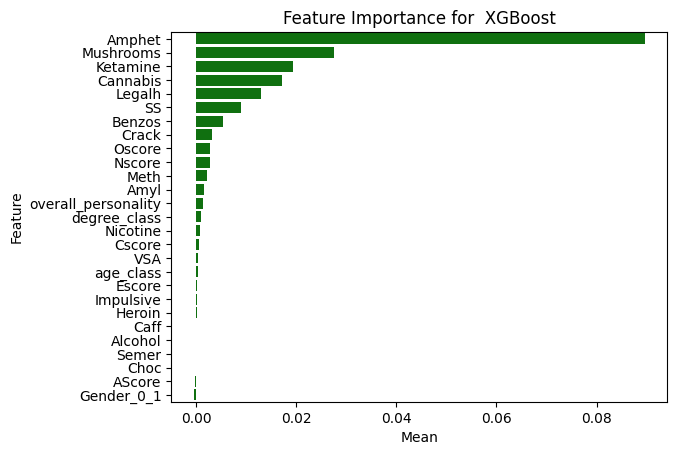

In [ ]:
sns.barplot(x = data_out['Mean'], y = data_out['Feature'], color = 'green')
plt.title('Feature Importance for  XGBoost')

Digital Twin Test Accuracy: 0.88
Confusion Matrix:
[[124  28]
 [ 18 206]]


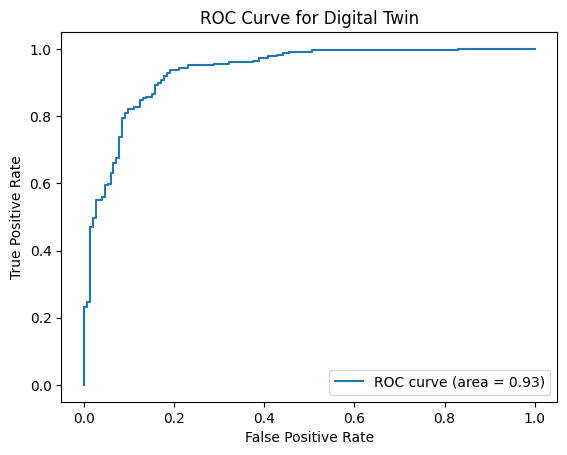

Patient 1 Treatment Plan:
Based on the patient's Nscore of 0 and a prediction probability of 0.10 for their condition, it appears that the patient may have a low level of neuroticism. With a model accuracy of 0.88, there is a high level of confidence in this prediction.

For a personalized treatment plan, it is important to consider the patient's individual characteristics and preferences. It would be beneficial to engage in psychotherapy or counseling sessions to address any underlying emotional or psychological issues that may be contributing to the low neuroticism levels. Additionally, stress-reducing techniques such as mindfulness meditation or yoga may help the patient manage any anxiety or stress they may experience.

In terms of medication, if necessary, selective serotonin reuptake inhibitors (SSRIs) or other antidepressants may be considered to help with any mood disturbances. It is important to consult with a healthcare provider to determine the most appropriate treatment pla

In [ ]:
import openai
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Set your OpenAI API key
openai.api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

# Define a cache to store responses
response_cache = {}

# Function to interact with GPT model
def chat_gpt(prompt):
    if prompt in response_cache:
        return response_cache[prompt]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )

    response_text = response.choices[0].message["content"].strip()
    response_cache[prompt] = response_text  # Cache the response
    return response_text

# Function to generate a personalized treatment plan
def generate_treatment_plan(patient_data, prediction, probability, accuracy, context=""):
    prompt = f"""
    Patient Data: {patient_data}
    Predicted Condition: {prediction}
    Prediction Probability: {probability:.2f}
    Model Accuracy: {accuracy:.2f}

    Context: {context}
    Generate a personalized treatment plan for the patient based on the above information, ensuring it adheres to best medical practices and patient preferences.
    Where the features include Age (Real) is the age of participant, Gender: Male or Female, Education: level of education of participant, Country: country of origin of the participant
    Ethnicity: ethnicity of participant, Nscore (Real) is NEO-FFI-R Neuroticism, Escore (Real) is NEO-FFI-R Extraversion, Oscore (Real) is NEO-FFI-R Openness to experience. Ascore (Real) is NEO-FFI-R Agreeableness.
    Cscore (Real) is NEO-FFI-R Conscientiousness. Impulsive (Real) is impulsiveness measured by BIS-11, SS (Real) is sensation seeing measured by ImpSS, Alcohol: alcohol consumption
    Amphet: amphetamines consumption, Amyl: nitrite consumption, Benzos: benzodiazepine consumption,Caff: caffeine consumption
    Cannabis: marijuana consumption, Choc: chocolate consumption, Coke: cocaine consumption, Crack: crack cocaine consumption, Ecstasy: ecstasy consumption, Heroin: heroin consumption, Ketamine: ketamine consumption
    Legalh: legal highs consumption, LSD: LSD consumption, Meth: methadone consumption, Mushroom: magic mushroom consumption
    Nicotine: nicotine consumption, Semer: class of fictitious drug Semeron consumption (i.e. control), VSA: class of volatile substance abuse consumption

    """
    return chat_gpt(prompt)

# Simulated function to retrieve documents (replace with your implementation)
def retrieve_documents(query):
    # Mock retrieval function (replace with real document retrieval logic)
    return ["Relevant treatment guideline 1", "Relevant treatment guideline 2"]

# Function to combine query and retrieved documents
def generate_response(query):
    retrieved_docs = retrieve_documents(query)

    # Combine the retrieved documents
    context = ' '.join(retrieved_docs)

    # Create the prompt by combining the query and context
    prompt = f"Query: {query}\nContext: {context}\nResponse:"

    # Generate the response using GPT-3.5
    response = chat_gpt(prompt)
    return response

# Save the cache to a file for persistence
def save_cache():
    with open('response_cache.pkl', 'wb') as f:
        pickle.dump(response_cache, f)

# Load data from digital twin predictions (replace with actual data)
digital_twin_preds = digital_twin_model(X_test)  # Replace with your model's prediction call
final_preds_binary = (digital_twin_preds >= 0.5).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(Y_test, final_preds_binary)
print(f"Digital Twin Test Accuracy: {accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(Y_test, final_preds_binary)
print(f"Confusion Matrix:\n{cm}")

# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, digital_twin_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Digital Twin')
plt.legend(loc="lower right")
plt.show()

# Generate personalized treatment plans
for idx, patient in enumerate(X_test):
    patient_data = patient
    prediction = final_preds_binary[idx]
    probability = digital_twin_preds[idx]

    # Generate treatment plan
    treatment_plan = generate_treatment_plan(
        patient_data=patient_data,
        prediction=prediction,
        probability=probability,
        accuracy=accuracy,
        context="Relevant treatment guidelines or patient preferences"
    )

    print(f"Patient {idx + 1} Treatment Plan:\n{treatment_plan}\n")

# Save the GPT response cache
save_cache()
